In [2]:
import numpy as np 
import pandas as pd

np.random.seed(23)

mu_vec1 = np.array([0, 0, 0])
cov_mat1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample, columns=['feature1', 'feature2', 'feature3'])
df['target'] = 1

mu_vec2 = np.array([1, 1, 1])
cov_mat2 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample, columns=['feature1', 'feature2', 'feature3'])
df1['target'] = 0

df = pd.concat([df, df1], ignore_index=True)

df = df.sample(40)


In [4]:
df.head()

,feature1,feature2,feature3,target
2,-0.367548,-1.137460,-1.322148,1
34,0.177061,-0.598109,1.226512,0
14,0.420623,0.411620,-0.071324,1
11,1.968435,-0.547788,-0.679418,1
12,-2.506230,0.146960,0.606195,1


In [5]:
import plotly.express as px

fig = px.scatter_3d(df,x=df['feature1'],y=df['feature2'],z=df['feature3'],color=df['target'].astype('str'))

fig.update_traces(marker=dict(size=12,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))

fig.show()

In [10]:
# Step 1 = Apply standard scalling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

In [ ]:
# Step 2 - Find covariance matrix

covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('covariance matrix:\n',covariance_matrix)

covariance matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [ ]:
# Step 3 - Find eigen values and eigen vactors

eigen_values , eigen_vectors = np.linalg.eig(covariance_matrix)

In [9]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [13]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

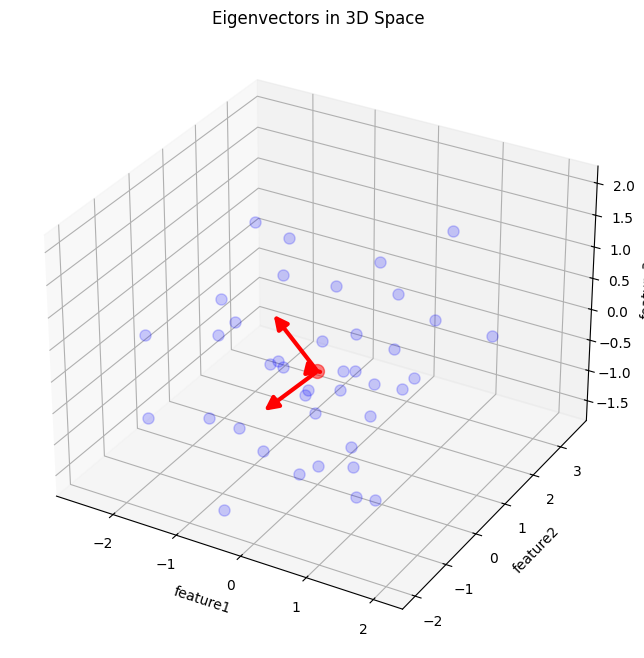

In [22]:
# ✅ Fix: Add do_3d_projection method
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib import pyplot as plt

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        return np.mean(zs)


# ✅ Extract feature data from df
features = df[['feature1', 'feature2', 'feature3']]

# ✅ Compute eigenvectors from covariance matrix
cov_matrix = np.cov(features.T)
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# Plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['feature1'], df['feature2'], df['feature3'], 'o', markersize=8, color='blue', alpha=0.2)
ax.plot([features['feature1'].mean()], [features['feature2'].mean()], [features['feature3'].mean()],
        'o', markersize=10, color='red', alpha=0.5)

# Draw eigenvectors as arrows
mean_vec = features.mean().values
for v in eigen_vectors.T:
    arrow = Arrow3D([mean_vec[0], mean_vec[0] + v[0]],
                    [mean_vec[1], mean_vec[1] + v[1]],
                    [mean_vec[2], mean_vec[2] + v[2]],
                    mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(arrow)

ax.set_xlabel('feature1')
ax.set_ylabel('feature2')
ax.set_zlabel('feature3')
plt.title('Eigenvectors in 3D Space')
plt.show()


In [23]:
pc = eigen_vectors[0:2]
pc

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442]])

In [24]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)

new_df = pd.DataFrame(transformed_df    ,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,0.599433,1.795862,1
1,1.056919,-0.212737,0
2,-0.271876,0.498222,1
3,-0.621586,0.023110,1
4,1.567286,1.730967,1


In [25]:
new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                                        selector=dict(mode='marker'))

fig.show()